In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext
import torchtext.transforms as T
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.text import build_vocab, is_longer_text
from torchlake.sequence_data.models.transformer import TransformerEncoder
from torchlake.text_classification.datasets.ag_news import CLASS_NAMES
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import AG_NEWS

In [2]:
torch.__version__

'2.1.0+cu118'

In [3]:
torchtext.__version__

'0.16.0+cpu'

# setting


In [4]:
batch_size = 128
CONTEXT = NlpContext()

In [5]:
tokenizer = get_tokenizer("basic_english")

In [6]:
artifact_path = Path("../../artifacts/transformer")
artifact_path.mkdir(exist_ok=True)

dataset_path = Path("../../data/AGNews")

In [7]:
DEVICE = torch.device(CONTEXT.device)

# dataset


In [8]:
NUM_CLASS = len(CLASS_NAMES)

In [9]:
MINIMUM_LENGTH = 5

In [10]:
def datapipe_factory(
    datapipe,
    minimum_length: int = 1,
    transform=None,
):
    datapipe = (
        datapipe
            .map(lambda pair: (pair[1], pair[0])) # label, text -> text, label
            .map(lambda pair: (pair[0], pair[1]-1))
            .map(lambda pair: (pair[0].strip(), pair[1]))
            .map(lambda pair: (pair[0].lower(), pair[1]))
            .filter(lambda pair: is_longer_text(pair[0], minimum_length))
            .map(
                lambda pair: (tokenizer(pair[0]), pair[1])
            )
    )

    if transform:
        datapipe = datapipe.map(lambda item: (transform(item[0]), item[1]))

    return datapipe

In [11]:
train_datapipe, test_datapipe = AG_NEWS(dataset_path.as_posix())

In [12]:
vocab = build_vocab(map(lambda x: x[0], datapipe_factory(train_datapipe)))

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [13]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

30335

In [14]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(CONTEXT.max_seq_len - 1),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [15]:
train_datapipe = datapipe_factory(
    train_datapipe,
    minimum_length=MINIMUM_LENGTH,
    transform=text_transform,
)

test_datapipe = datapipe_factory(
    test_datapipe,
    minimum_length=MINIMUM_LENGTH,
    transform=text_transform,
)

In [16]:
for text, label in train_datapipe:
    print(text.shape)
    print(label)
    break

torch.Size([256])
2


In [17]:
NUM_WORKERS = get_num_workers()

In [18]:
def collate_fn(batch: list):
    text_placeholder, label_placeholder = [], []
    for text, label in batch:
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.LongTensor(label_placeholder)

In [19]:
train_dataloader = DataLoader(
    train_datapipe,
    batch_size=batch_size,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_datapipe,
    batch_size=batch_size,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
)

In [20]:
for text, label in train_dataloader:
    print(text.shape, label.shape)
    break

torch.Size([128, 256]) torch.Size([128])


d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


# model


In [21]:
HIDDEN_DIM = 256

In [22]:
from torch import nn

# just like ViT
class TransformerDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.att = TransformerEncoder(
            VOCAB_SIZE,
            HIDDEN_DIM,
            num_layers = 6,
            num_heads = 8,
            padding_idx=CONTEXT.padding_idx,
        )
        self.fc = nn.Linear(HIDDEN_DIM, NUM_CLASS)

    def forward(self, x):        
        return self.fc(self.att(x)[:, 0])

In [23]:
model = TransformerDiscriminator().to(DEVICE)

In [24]:
torchinfo.summary(model)

Layer (type:depth-idx)                                                 Param #
TransformerDiscriminator                                               --
├─TransformerEncoder: 1-1                                              --
│    └─ModuleDict: 2-1                                                 --
│    │    └─PositionEncoding: 3-1                                      --
│    │    └─Embedding: 3-2                                             7,765,760
│    │    └─Dropout: 3-3                                               --
│    └─Sequential: 2-2                                                 --
│    │    └─TransformerEncoderBlock: 3-4                               789,760
│    │    └─TransformerEncoderBlock: 3-5                               789,760
│    │    └─TransformerEncoderBlock: 3-6                               789,760
│    │    └─TransformerEncoderBlock: 3-7                               789,760
│    │    └─TransformerEncoderBlock: 3-8                               789,760
│

# train

In [25]:
EPOCHES = 10

In [26]:
trainer = ClassificationTrainer(EPOCHES, DEVICE)

In [27]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [28]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [29]:
training_loss = trainer.run(train_dataloader, model, optimizer, criterion, scheduler)

938it [04:12,  3.72it/s]


epoch 1 : 0.3221207831396477


938it [04:14,  3.69it/s]


epoch 2 : 0.2260042939072987


938it [04:14,  3.68it/s]


epoch 3 : 0.2038360163807742


938it [04:12,  3.71it/s]


epoch 4 : 0.18866281023125914


938it [04:14,  3.69it/s]


epoch 5 : 0.17766677440483686


938it [04:14,  3.68it/s]


epoch 6 : 0.1651472176141195


938it [04:09,  3.75it/s]


epoch 7 : 0.1581976563453293


938it [04:04,  3.84it/s]


epoch 8 : 0.15023241562248546


938it [04:10,  3.74it/s]


epoch 9 : 0.14290984048406835


938it [04:21,  3.59it/s]

epoch 10 : 0.13701544406968774


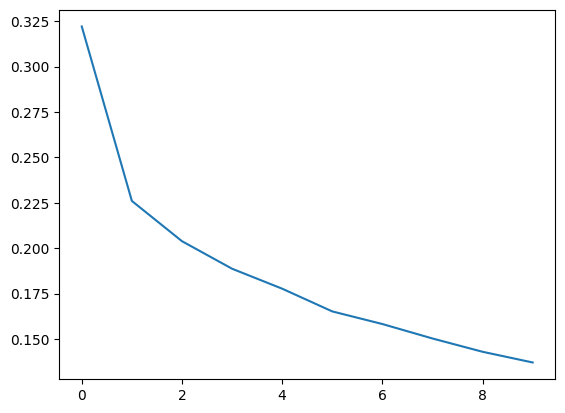

In [30]:
plt.plot(training_loss)

# inference


In [31]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE)

In [32]:
confusion_matrix = evaluator.run(test_dataloader, model)

60it [00:05, 10.64it/s]

[[1732   56   82   30]
 [  39 1841   15    5]
 [  90   33 1640  137]
 [ 138   45  187 1530]]


In [33]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(CLASS_NAMES , per_class_acc)

world     : 0.911578947368421
sports    : 0.9689473684210527
business  : 0.8631578947368421
science   : 0.8052631578947368


In [34]:
per_class_acc.mean()

0.8872368421052632

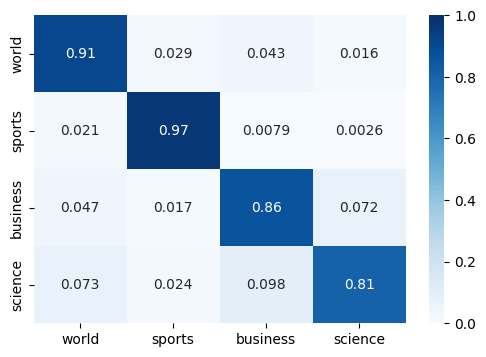

In [35]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    CLASS_NAMES,
    "Blues",
    annot=True,
    figsize=(6, 4),
)

In [36]:
model_path = artifact_path.joinpath("transformer.agnews.pth")

In [37]:
torch.save(model.state_dict(), model_path)

In [38]:
get_file_size(model_path)

'47.83MiB'

In [39]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>